# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!gdown 'https://drive.google.com/uc?id=1-mPc3Mn8Qask6IKM47XY6ODVsA1oL3xi'

Downloading...
From: https://drive.google.com/uc?id=1-mPc3Mn8Qask6IKM47XY6ODVsA1oL3xi
To: /content/best-dataset.zip
133MB [00:00, 145MB/s]


In [2]:
!unzip best-dataset.zip

Archive:  best-dataset.zip
   creating: best-dataset/
   creating: best-dataset/dataset/
  inflating: best-dataset/dataset/.DS_Store  
   creating: best-dataset/dataset/without_mask/
  inflating: best-dataset/dataset/without_mask/.DS_Store  
  inflating: best-dataset/dataset/without_mask/0.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_aidai_0014.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_aidai_0029.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_aidai_0043.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_aidai_0074.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_aidai_0084.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_aidai_0136.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_anhu_0004.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_anhu_0020.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_anhu_0025.jpg  
  inflating: best-dataset/dataset/without_mask/0_0_anhu_0027.jpg  
  inflating: best-dataset/d

In [3]:
!rm -rf /content/sample_data
!rm best-dataset.zip

# Data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
imagePaths = list(paths.list_images('/content/best-dataset/dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

print(data.shape)
print(labels.shape)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(3833, 224, 224, 3)
(3833,)


In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 38s 320ms/step - loss: 0.5523 - accuracy: 0.7355 - val_loss: 0.1090 - val_accuracy: 0.9739
Epoch 2/20
95/95 [==============================] - 29s 310ms/step - loss: 0.1396 - accuracy: 0.9480 - val_loss: 0.0708 - val_accuracy: 0.9817
Epoch 3/20
95/95 [==============================] - 30s 311ms/step - loss: 0.0822 - accuracy: 0.9707 - val_loss: 0.0610 - val_accuracy: 0.9817
Epoch 4/20
95/95 [==============================] - 29s 310ms/step - loss: 0.0674 - accuracy: 0.9732 - val_loss: 0.0495 - val_accuracy: 0.9831
Epoch 5/20
95/95 [==============================] - 29s 308ms/step - loss: 0.0596 - accuracy: 0.9811 - val_loss: 0.0463 - val_accuracy: 0.9844
Epoch 6/20
95/95 [==============================] - 29s 308ms/step - loss: 0.0444 - accuracy: 0.9857 - val_loss: 0.0439 - val_accuracy: 0.9844
Epoch 7/20
95/95 [==============================] - 29s 310ms/step - loss: 0.0441 - accuracy

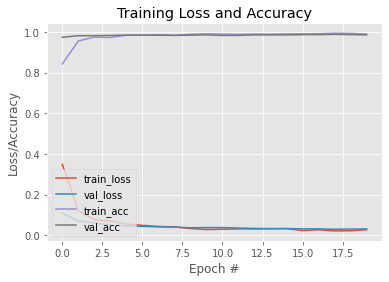

In [9]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [10]:
#To save the trained model
model.save('mask_detector.h5')